In [ ]:
pip install tensorflow==2.8.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from prophet import Prophet
import matplotlib.pyplot as plt


In [ ]:
# Fungsi untuk membuat data time series
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


In [ ]:
# Fungsi untuk membuat model LSTM
def create_lstm_model(optimizer='adam', learn_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/skripsi/ANTM.JK.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,765.0,765.0,765.0,765.0,703.290466,0
1,2019-01-02,770.0,775.0,735.0,740.0,680.307129,53128900
2,2019-01-03,750.0,755.0,740.0,750.0,689.500488,34641100
3,2019-01-04,750.0,765.0,745.0,760.0,698.693848,59878500
4,2019-01-07,775.0,785.0,765.0,770.0,707.887146,65853100
...,...,...,...,...,...,...,...
1227,2023-12-21,1635.0,1645.0,1625.0,1635.0,1635.000000,14967800
1228,2023-12-22,1640.0,1665.0,1640.0,1665.0,1665.000000,24415400
1229,2023-12-27,1675.0,1745.0,1675.0,1735.0,1735.000000,86013100
1230,2023-12-28,1750.0,1800.0,1705.0,1715.0,1715.000000,115723900


In [ ]:
data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
data

,Date,Close
0,2019-01-01,765.0
1,2019-01-02,740.0
2,2019-01-03,750.0
3,2019-01-04,760.0
4,2019-01-07,770.0
...,...,...
1227,2023-12-21,1635.0
1228,2023-12-22,1665.0
1229,2023-12-27,1735.0
1230,2023-12-28,1715.0


In [ ]:
data.describe()

,Close
count,1232.000000
mean,1628.190747
std,705.776451
min,348.000000
25%,880.000000
50%,1850.000000
75%,2242.500000
max,3190.000000


In [ ]:
data

,Date,Close
0,2019-01-01,765.0
1,2019-01-02,740.0
2,2019-01-03,750.0
3,2019-01-04,760.0
4,2019-01-07,770.0
...,...,...
1227,2023-12-21,1635.0
1228,2023-12-22,1665.0
1229,2023-12-27,1735.0
1230,2023-12-28,1715.0


In [ ]:
# Ubah data menjadi format yang sesuai
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Close']]
data = data.set_index('Date')
data = data.dropna()


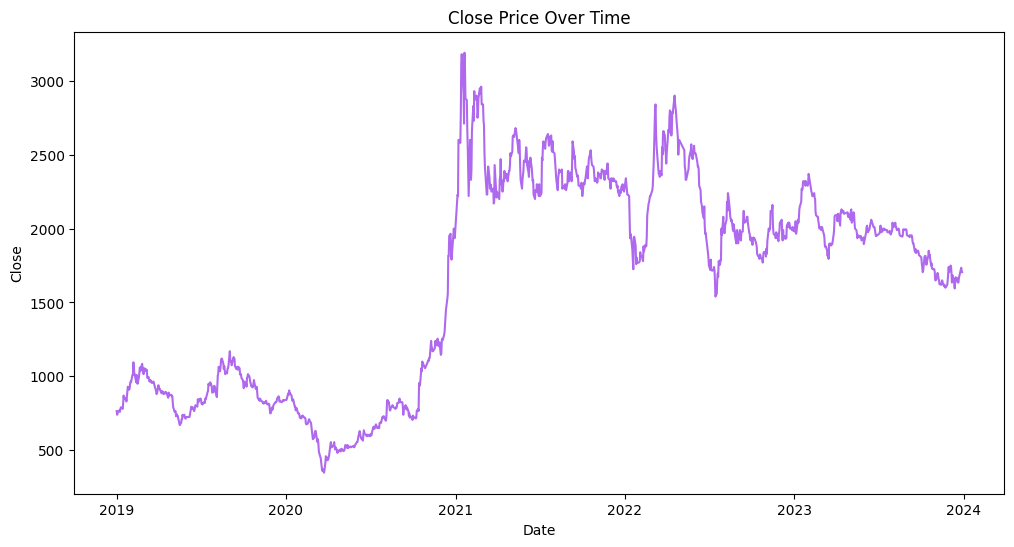

In [ ]:
# Plot the close price over time using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], color='#AF69EE')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Close Price Over Time')
plt.show()

In [ ]:
# Fungsi untuk normalisasi data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [ ]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data[1227:1234]

array([[0.45285011],
       [0.46340605],
       [0.48803659],
       [0.4809993 ],
       [0.47748065]])

In [ ]:
# Split data menjadi data latih dan data uji (80/20)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [ ]:
train_size

985

In [ ]:
test_size

247

In [ ]:
# Buat data time series dengan time steps = 1
time_steps = 1
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [ ]:
# Reshape data untuk model LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Buat model regressor Keras
model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Tentukan hyperparameter untuk tuning
param_grid = {'batch_size': [32, 64],
              'epochs': [50, 100],
              'optimizer': ['adam'],
              'learn_rate': [0.001, 0.01]}

<ipython-input-18-a6ac77aaa738>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [ ]:
# Lakukan tuning hyperparameter menggunakan GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train, y_train)
grid_result


Best: -0.000456 using {'batch_size': 32, 'epochs': 100, 'learn_rate': 0.01, 'optimizer': 'adam'}


In [ ]:

# Cetak hasil hyperparameter terbaik
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# Buat dan latih model LSTM dengan hyperparameter terbaik
best_params = grid_result.best_params_
lstm_model = create_lstm_model(optimizer=best_params['optimizer'], learn_rate=best_params['learn_rate'])
lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=2)

Epoch 1/100
31/31 - 4s - loss: 0.1842 - 4s/epoch - 114ms/step
Epoch 2/100
31/31 - 0s - loss: 0.0548 - 111ms/epoch - 4ms/step
Epoch 3/100
31/31 - 0s - loss: 0.0233 - 118ms/epoch - 4ms/step
Epoch 4/100
31/31 - 0s - loss: 0.0127 - 114ms/epoch - 4ms/step
Epoch 5/100
31/31 - 0s - loss: 0.0049 - 116ms/epoch - 4ms/step
Epoch 6/100
31/31 - 0s - loss: 0.0015 - 114ms/epoch - 4ms/step
Epoch 7/100
31/31 - 0s - loss: 8.2974e-04 - 128ms/epoch - 4ms/step
Epoch 8/100
31/31 - 0s - loss: 7.9769e-04 - 116ms/epoch - 4ms/step
Epoch 9/100
31/31 - 0s - loss: 8.0279e-04 - 116ms/epoch - 4ms/step
Epoch 10/100
31/31 - 0s - loss: 7.7544e-04 - 118ms/epoch - 4ms/step
Epoch 11/100
31/31 - 0s - loss: 7.7197e-04 - 116ms/epoch - 4ms/step
Epoch 12/100
31/31 - 0s - loss: 7.4646e-04 - 110ms/epoch - 4ms/step
Epoch 13/100
31/31 - 0s - loss: 7.3256e-04 - 113ms/epoch - 4ms/step
Epoch 14/100
31/31 - 0s - loss: 7.2263e-04 - 177ms/epoch - 6ms/step
Epoch 15/100
31/31 - 0s - loss: 7.0910e-04 - 180ms/epoch - 6ms/step
Epoch 16/100
3

In [ ]:
# Prediksi menggunakan model LSTM
y_pred_lstm = lstm_model.predict(X_test)

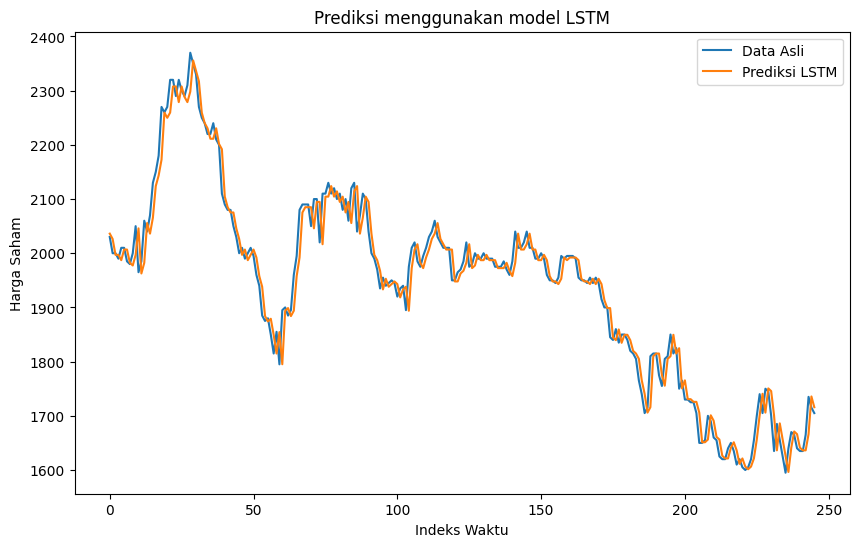

In [ ]:
# Denormalisasi hasil prediksi dan data asli
y_pred_lstm_denorm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Memplot hasil prediksi dan data asli
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Data Asli')
plt.plot(y_pred_lstm_denorm, label='Prediksi LSTM')
plt.xlabel('Indeks Waktu')
plt.ylabel('Harga Saham')
plt.title('Prediksi menggunakan model LSTM')
plt.legend()
plt.show()

In [ ]:
# Membuat array untuk indeks waktu
indeks_waktu = np.arange(len(y_test))

# Membuat dataframe untuk data asli dan prediksi
df = pd.DataFrame({'Waktu': indeks_waktu, 'Data Asli': y_test_denorm.flatten(), 'Prediksi LSTM': y_pred_lstm_denorm.flatten()})

# Menampilkan dataframe
print(df)


     Waktu  Data Asli  Prediksi LSTM
0        0     2270.0    2330.818359
1        1     2250.0    2272.673340
2        2     2240.0    2253.243408
3        3     2220.0    2243.519287
4        4     2220.0    2224.053711
..     ...        ...            ...
248    248     1470.0    1514.762207
249    249     1500.0    1479.490356
250    250     1550.0    1509.725952
251    251     1515.0    1560.051025
252    252     1480.0    1524.832397

[253 rows x 3 columns]


In [ ]:
# Evaluasi model LSTM
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm) / y_test)) * 100
r2_lstm = r2_score(y_test, y_pred_lstm)

print("LSTM Model Evaluation:")
print("MSE:", mse_lstm)
print("MAE:", mae_lstm)
print("MAPE:", mape_lstm)
print("R^2:", r2_lstm)

LSTM Model Evaluation:
MSE: 0.0001346231587117542
MAE: 0.008931317192657587
MAPE: 15.16764447712319
R^2: 0.9712395782114336


In [ ]:
scaled_data

array([[0.13793103],
       [0.14144968],
       [0.14496833],
       ...,
       [0.42294159],
       [0.41062632],
       [0.39831105]])

,ds,y
1227,2023-12-21,1635.0
1228,2023-12-22,1665.0
1229,2023-12-27,1735.0
1230,2023-12-28,1715.0
1231,2023-12-29,1705.0


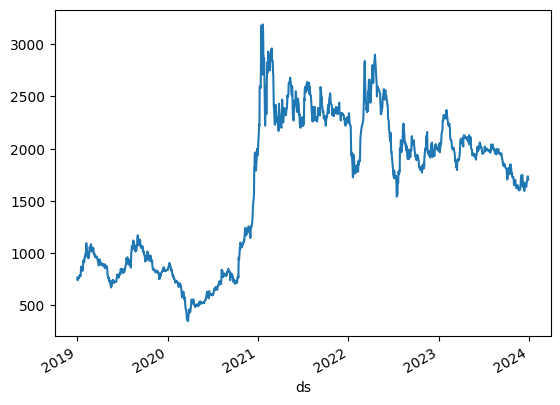

In [ ]:
# Buat dan latih model Prophet
prophet_model = Prophet()
df_prophet = pd.DataFrame(data={'ds': data.index, 'y': data['Close'].values})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet.set_index('ds').y.plot()
df_prophet.tail(5)

In [ ]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1232 non-null   datetime64[ns]
 1   y       1232 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.4 KB


In [ ]:
!pip install requests beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup

# Array untuk menyimpan tanggal hari libur
hdholidays = []
for hdyear in range(2019, 2024):
    # URL situs penyedia hari libur
    hdurl = f'https://www.officeholidays.com/countries/indonesia/{hdyear}'

    # Mengambil konten halaman web
    hdresponse = requests.get(hdurl)
    hdsoup = BeautifulSoup(hdresponse.text, 'html.parser')

    # Mencari elemen yang berisi data hari libur
    hdholiday_elements = hdsoup.find_all('time')

    # Mendapatkan tanggal hari libur dari elemen HTML
    for hdelement in hdholiday_elements:
        hdholiday_date = hdelement['datetime']
        hdholidays.append(hdholiday_date)

# Menampilkan array tanggal hari libur
print(hdholidays)

['2019-01-01', '2019-02-05', '2019-03-07', '2019-04-03', '2019-04-17', '2019-04-19', '2019-05-01', '2019-05-19', '2019-05-30', '2019-06-01', '2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06', '2019-06-07', '2019-08-11', '2019-08-17', '2019-09-01', '2019-11-09', '2019-12-24', '2019-12-25', '2020-01-01', '2020-01-25', '2020-03-22', '2020-03-25', '2020-04-10', '2020-05-01', '2020-05-07', '2020-05-21', '2020-05-22', '2020-05-24', '2020-05-25', '2020-06-01', '2020-07-31', '2020-08-17', '2020-08-20', '2020-08-21', '2020-10-28', '2020-10-29', '2020-10-30', '2020-12-09', '2020-12-24', '2020-12-25', '2020-12-31', '2021-01-01', '2021-02-12', '2021-03-11', '2021-03-14', '2021-04-02', '2021-05-01', '2021-05-12', '2021-05-13', '2021-05-13', '2021-05-14', '2021-05-26', '2021-06-01', '2021-07-20', '2021-08-11', '2021-08-17', '2021-10-20', '2021-12-25', '2022-01-01', '2022-02-01', '2022-02-28', '2022-03-03', '2022-04-15', '2022-04-29', '2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04', '2022

In [ ]:
# Bagi data menjadi data latih dan data uji
train, test = train_test_split(df_prophet, test_size=0.2, shuffle=False)  # Menggunakan shuffle=False untuk memastikan data diurutkan sesuai tanggal

In [ ]:
train

,ds,y
0,2019-01-01,765.0
1,2019-01-02,740.0
2,2019-01-03,750.0
3,2019-01-04,760.0
4,2019-01-07,770.0
...,...,...
980,2022-12-14,1940.0
981,2022-12-15,1935.0
982,2022-12-16,2020.0
983,2022-12-19,2040.0


In [ ]:
test

,ds,y
985,2022-12-21,2040.0
986,2022-12-22,2030.0
987,2022-12-23,2000.0
988,2022-12-26,2000.0
989,2022-12-27,1990.0
...,...,...
1227,2023-12-21,1635.0
1228,2023-12-22,1665.0
1229,2023-12-27,1735.0
1230,2023-12-28,1715.0


In [ ]:
# Identifikasi hari libur
holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(hdholidays), # Tambahkan tanggal hari libur sesuai kebutuhan
    'lower_window': 0,
    'upper_window': 1,
})


In [ ]:
model = Prophet(
        daily_seasonality=True,
        growth='linear',
        holidays=(holidays)  # add Indonesian holidays
)

In [ ]:
model = Prophet(
        daily_seasonality=True
 # add Indonesian holidays
)

In [ ]:
# Buat dan latih model
model = Prophet(holidays=holidays,
                seasonality_mode='multiplicative',  # Mode musiman
                yearly_seasonality=False,             # Musiman tahunan
                weekly_seasonality=False,            # Musiman mingguan
                daily_seasonality=True,
                changepoint_prior_scale=0.01,
                seasonality_prior_scale=0.01,
                holidays_prior_scale=0.01)

# Menambahkan komponen musiman dan hari libur
model.add_seasonality(name='weekly', period=7, fourier_order=3)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

# Menambahkan hari libur
model.add_country_holidays(country_name='ID')

In [ ]:
# Melatih model
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzqgo3z6x/3fh820z7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzqgo3z6x/bsdrh2ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18815', 'data', 'file=/tmp/tmpzqgo3z6x/3fh820z7.json', 'init=/tmp/tmpzqgo3z6x/bsdrh2ca.json', 'output', 'file=/tmp/tmpzqgo3z6x/prophet_modellx0xbx1h/prophet_model-20240523054439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:44:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Buat dataframe untuk prediksi
future = model.make_future_dataframe(periods=len(test))  # Jumlah periode untuk data uji sama dengan panjang data uji
future.tail(5)



,ds
1227,2023-08-20
1228,2023-08-21
1229,2023-08-22
1230,2023-08-23
1231,2023-08-24


In [ ]:
# Lakukan prediksi
forecast = model.predict(test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [ ]:
# Evaluasi model
y_true = test['y'].values
y_pred = forecast['yhat'].values[-len(test):]  # Ambil nilai prediksi untuk data uji
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 34151.21792157691
Mean Absolute Error (MAE): 158.79570879801594
Mean Absolute Percentage Error (MAPE): 0.08039018179812552
R-squared (R^2): -0.08292831122324729


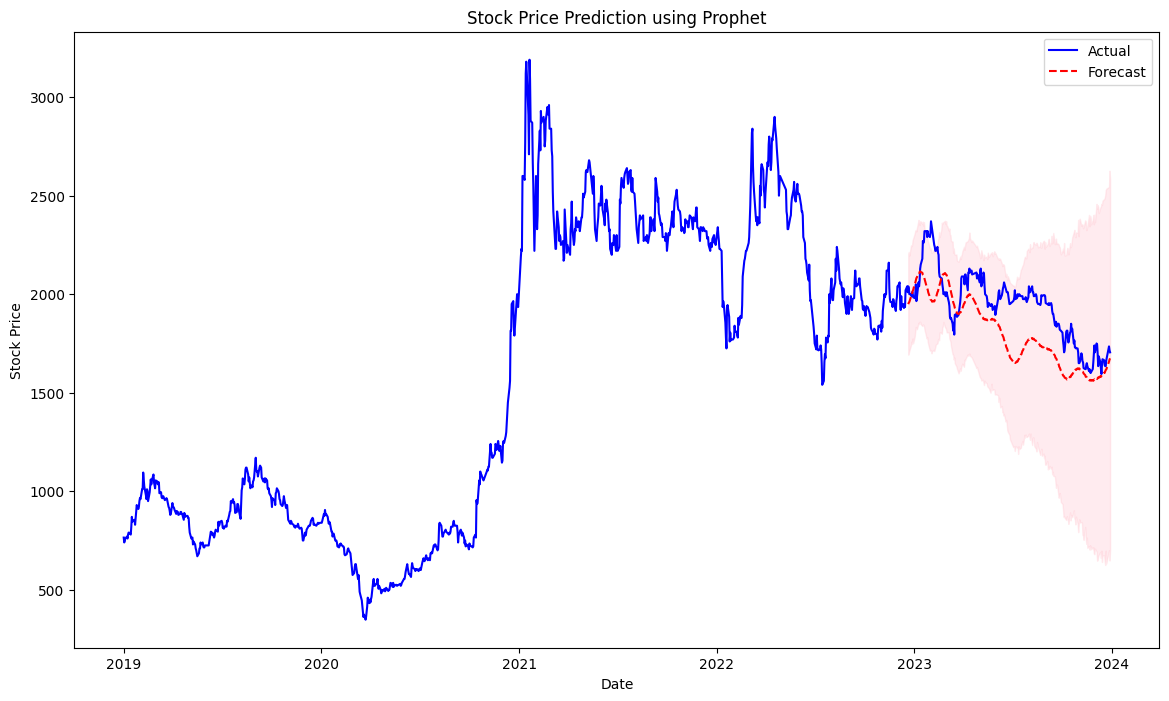

In [ ]:
# Visualisasi data asli dan hasil prediksi
fig, ax = plt.subplots(figsize=(14, 8))

# Data asli
ax.plot(df_prophet['ds'], df_prophet['y'], color='blue', label='Actual')

# Prediksi
ax.plot(forecast['ds'], forecast['yhat'], linestyle='--', color='red', label='Forecast')
# Interval kepercayaan
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

# Pengaturan label dan judul
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction using Prophet')
ax.legend()

# Tampilkan plot
plt.show()

In [ ]:
# Buat DataFrame untuk melihat hasil prediksi dan aktual
results = test[['ds', 'y']].copy()
results['yhat'] = y_pred

In [ ]:
results

,ds,y,yhat
985,2022-12-21,2040.0,1949.390977
986,2022-12-22,2030.0,1957.629167
987,2022-12-23,2000.0,1960.552191
988,2022-12-26,2000.0,1987.027253
989,2022-12-27,1990.0,1991.005979
...,...,...,...
1227,2023-12-21,1635.0,1615.887954
1228,2023-12-22,1665.0,1618.058350
1229,2023-12-27,1735.0,1657.243394
1230,2023-12-28,1715.0,1668.609160


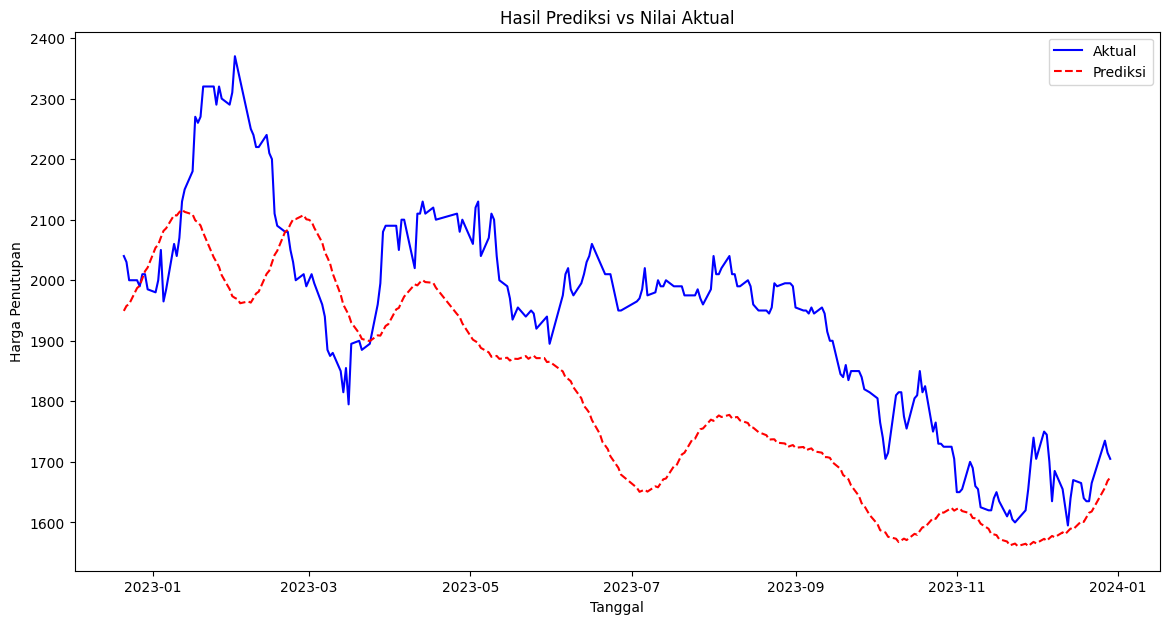

In [ ]:
# Plot hasil prediksi dan nilai aktual
plt.figure(figsize=(14, 7))
plt.plot(results['ds'], results['y'], label='Aktual', color='blue')
plt.plot(results['ds'], results['yhat'], label='Prediksi', color='red', linestyle='dashed')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.title('Hasil Prediksi vs Nilai Aktual')
plt.legend()
plt.show()